# BPTI analysis

## Setup

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

## Load Data

In [2]:
from stateinterpreter import load_dataframe

kBT = 2.5
BPTI_data_path = '../../data/md_datasets/BPTI-unbiased/'
colvar_file = BPTI_data_path + 'deeptica/v2-lag100-nodes1024-256-64-3/COLVAR.csv'
traj_dict = {
        'trajectory' : BPTI_data_path+'trajectory.trr',
        'topology' : BPTI_data_path+'topology.pdb'
    }

start,stop,stride=0,None,1
colvar = load_dataframe(colvar_file, start, stop, stride) #.drop(['idx', 'time'], axis=1)

colvar.head()

,DeepTICA 1,DeepTICA 2,DeepTICA 3
0,0.818829,0.936690,0.391020
1,0.826180,1.034729,0.398371
2,0.837799,1.079363,0.427052
3,0.822358,0.859656,0.411466
4,0.819523,0.936758,0.413024


## Compute descriptors

In [3]:
from stateinterpreter.utils import load_trajectory
from stateinterpreter.descriptors import compute_descriptors

traj = load_trajectory(traj_dict,start,stop,stride)
descriptors, feats_info = compute_descriptors( traj, descriptors = ['dihedrals',  'disulfide', 'hbonds_distances', 'hbonds_contacts'] )

['DISULFIDE dih CYS5_CYS55', 'DISULFIDE sin_dih CYS5_CYS55', 'DISULFIDE cos_dih CYS5_CYS55', 'DISULFIDE dih CYS14_CYS38', 'DISULFIDE sin_dih CYS14_CYS38', 'DISULFIDE cos_dih CYS14_CYS38', 'DISULFIDE dih CYS30_CYS51', 'DISULFIDE sin_dih CYS30_CYS51', 'DISULFIDE cos_dih CYS30_CYS51']
{'DISULFIDE dih CYS5_CYS55': {'atoms': [76, 77, 862, 861], 'group': 'CYS5_CYS55'}, 'DISULFIDE sin_dih CYS5_CYS55': {'atoms': [76, 77, 862, 861], 'group': 'CYS5_CYS55'}, 'DISULFIDE cos_dih CYS5_CYS55': {'atoms': [76, 77, 862, 861], 'group': 'CYS5_CYS55'}, 'DISULFIDE dih CYS14_CYS38': {'atoms': [204, 205, 589, 588], 'group': 'CYS14_CYS38'}, 'DISULFIDE sin_dih CYS14_CYS38': {'atoms': [204, 205, 589, 588], 'group': 'CYS14_CYS38'}, 'DISULFIDE cos_dih CYS14_CYS38': {'atoms': [204, 205, 589, 588], 'group': 'CYS14_CYS38'}, 'DISULFIDE dih CYS30_CYS51': {'atoms': [476, 477, 797, 796], 'group': 'CYS30_CYS51'}, 'DISULFIDE sin_dih CYS30_CYS51': {'atoms': [476, 477, 797, 796], 'group': 'CYS30_CYS51'}, 'DISULFIDE cos_dih C

Compute SASA contributions to each residues with mdtraj

In [4]:
#calculate descriptors
import mdtraj as md

mode = 'residue'

traj = md.load(traj_dict['trajectory'], top=traj_dict['topology'], stride=stride)
sasa = md.shrake_rupley(traj,mode=mode)

print(sasa.shape)

names = []
#feats_info = {}

table, bonds = traj.top.to_dataframe()

if mode == 'atom':
    for idx in range(traj.n_atoms):
        name = 'SASA '+str(traj.top.atom(idx))
        names.append(name)
        feats_info[name] = {
            'atoms': [idx],
            'group': table["resName"][idx] + table["resSeq"][idx].astype("str")
        }
elif mode == 'residue':
    for res in traj.top.residues:
        name = 'SASA '+str(res)
        names.append(name)
        feats_info[name] = {
            #'atoms': [idx],
            'group': str(res)
        }
sasa = pd.DataFrame(sasa, columns=names) 

descriptors = pd.concat([descriptors,sasa],axis=1)

(103125, 58)


In [5]:
descriptors

,phi ARG1,phi PRO2,phi ASP3,phi PHE4,phi CYS5,phi LEU6,phi GLU7,phi PRO8,phi PRO9,phi TYR10,...,SASA GLU49,SASA ASP50,SASA CYS51,SASA MET52,SASA ARG53,SASA THR54,SASA CYS55,SASA GLY56,SASA GLY57,SASA ALA58
0,-0.928120,-1.185577,-1.349078,-1.548187,-1.579240,-1.846611,-1.064505,-1.255080,-2.761577,-1.062120,...,1.249677,0.275696,0.0,1.181362,1.798351,0.535614,0.000000e+00,0.521890,0.460957,1.328122
1,-1.204217,-0.819093,-1.366774,-1.207060,-1.631480,-1.286212,-1.051641,-1.207276,-2.381278,-1.482136,...,1.222329,0.436374,0.0,1.402522,1.870236,0.455180,2.260575e-02,0.373593,0.800718,1.374059
2,-1.326612,-1.321369,-1.044347,-0.989763,-1.693655,-1.385733,-1.025913,-1.219706,-2.409959,-1.394293,...,1.131043,0.143955,0.0,1.110286,1.934112,0.452785,2.168415e-03,0.131982,0.489193,1.641537
3,-1.010888,-0.981281,-1.378821,-1.297737,-1.384076,-1.338371,-1.178990,-1.479505,-2.203393,-1.138228,...,1.144953,0.322470,0.0,0.660122,2.095870,0.519053,2.394451e-06,0.263163,0.554062,1.796579
4,-1.348981,-1.135486,-1.431116,-1.108242,-2.942399,-0.936048,-1.197234,-1.163973,-1.863133,-1.274724,...,1.459088,0.527855,0.0,0.877392,2.241290,0.520313,2.716426e-09,0.218849,0.583376,1.433574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103120,-1.310206,-0.771593,-1.065712,-1.210880,-1.686351,-2.014777,-1.312813,-1.314016,-1.432150,-2.693534,...,1.104613,0.553409,0.0,0.871810,1.973288,0.569353,5.576282e-09,0.373503,0.599514,1.496040
103121,-1.029725,-0.932976,-1.195929,-1.144988,-1.590937,-2.406950,-1.173813,-1.040796,-0.542891,-2.315906,...,1.411432,0.367121,0.0,0.784554,1.682969,0.459669,6.225837e-12,0.464457,0.399868,1.276764
103122,-1.205671,-1.312187,-1.370838,-1.073652,-1.781101,-1.294194,-0.801391,-1.633125,-2.131662,-1.367206,...,1.239789,0.450235,0.0,1.117825,1.840205,0.456592,6.951357e-15,0.344495,0.316335,1.336097
103123,-1.078254,-1.020180,-1.332535,-1.310682,-1.419830,-2.245114,-1.272896,-1.252576,-2.390976,-1.544976,...,1.033351,0.350956,0.0,1.103749,1.818960,0.525961,3.053586e-02,0.384847,0.641501,1.888945


## Identify metastable states (hierarchical search)

/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/utils/hierarchical.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  logweight = logweights[[parent_mask]]


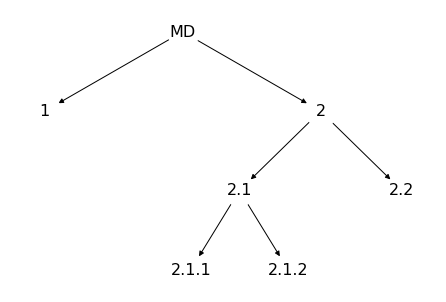

In [6]:
from stateinterpreter.utils.hierarchical import state_tree,hierarchy_pos,generate_state_labels_from_tree

cvs = colvar[['DeepTICA 1','DeepTICA 2','DeepTICA 3']].values
bandwidth = 0.1
logweights= np.ones(len(colvar))

# build tree of metastable states
T = state_tree(cvs, bandwidth , logweights=logweights)

# draw tree
pos = hierarchy_pos(T)
options = {
    "with_labels": True,
    "font_size": 16,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "white",
    "linewidths": 1,
    "width": 1,
}

nx.draw(T, pos, **options)

# generate state_labels for classification
labels_list = generate_state_labels_from_tree(T, root='MD', fes_threshold=1 ) 

## Train classifier

Training helper function

In [7]:
from stateinterpreter.utils.plot import paletteFessa,plot_fes
from stateinterpreter.utils.metrics import get_basis_quality,get_best_reg
from itertools import cycle

def train(cv_list,descriptors,states_labels=None,mask=None,merge_states=None,states_subset=None,color=None):
    # apply mask if given
    if mask is not None:
        cv = colvar[mask].reset_index()
        desc = descriptors[mask].reset_index()
        logw = None
        if logweights is not None:
            logw = logweights[mask]
            if type(logw) == pd.DataFrame:
                logw = logw.reset_index()
    else:
        cv = colvar
        desc = descriptors
        logw = logweights

    ### identify states if states_labels is None
    if states_labels is None:
        states_labels = identify_metastable_states(cv, cv_list, kBT, bandwidth, logweights=logw, fes_cutoff=kBT, gradient_descent_iterates=gradient_descent_iterates)
    
    # merge states if requested 
    if merge_states is not None:
        for pair in merge_states:
            states_labels.loc[states_labels['labels'] == pair[1], 'labels'] = pair[0]
    
    # classify
    sample_obj, features_names = prepare_training_dataset(desc, states_labels, num_samples, regex_filter=select_feat , states_subset=states_subset) 
    classifier = Classifier(sample_obj, features_names)
    classifier.compute(regularizers, max_iter= 10000) #, groups=groups)

    # get best reg
    reg,acc,num = get_best_reg(classifier)
    print(f'log_10 (lambda) : {np.round(np.log10(reg),3)}')
    print(f'Accuracy        : {np.round(acc*100,0)} %')
    print(f'No. features    : {num}')

    # get basis quality
    quality = get_basis_quality(classifier)
    print(f'Basis quality   : {quality} (lower the better)')

    # count states
    num_states = len(classifier.classes)
    num_histo = num_states if num_states>2 else 1
    
    # classes names
    relevant_feat = classifier.feature_summary(reg)
    classes_names = classifier.classes

    fig = plt.figure(figsize=(13.5,3), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(num_histo, 3, figure=fig)
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[:, 1])
    axs_histo = []
    for i in range(num_histo):
        axs_histo.append(fig.add_subplot(gs[i, 2]))
    ax = ax1

    # COLOR 
    if color is None:
        colors = cycle(iter(paletteFessa[::-1]))
        global global_states_no 
        for i in range(global_states_no):
            next(colors)
        color = [next(colors) for i in range(5)]

    # PLOT FES
    cv_plot = cv [states_labels['labels'] != 'undefined']
    logw_plot=None
    if logw is not None:
        logw_plot = logw[states_labels['labels'] != 'undefined']
    plot_fes(cv_plot[cv_list],bandwidth,states_labels,logweights=logw_plot,num_samples=200,states_subset=states_subset,ax=ax, colors=color)

    # plot classfier
    ax = ax2
    _, ax_twin = plot_classifier_complexity_vs_accuracy(classifier, ax = ax)
    ax.axvline(np.log10(reg),linestyle='dotted',color='k')
    ax.text(np.log10(reg)+0.02,acc+.05,f'{np.round(acc*100,1)}%',fontsize=12,color='fessa0')
    ax_twin.text(np.log10(reg)+0.02,num+0.5,f'{num}',fontsize=12,color='fessa1')

    #print features
    classifier.print_selected(reg)
    
    plot_histogram_features(desc, states_labels, classes_names, relevant_feat, axs = axs_histo, height=1, colors=color)

    # INCREASE COUNTER
    global_states_no += num_states

    return (cv_list,states_labels,features_names,classifier,reg)

Choose descriptors

In [33]:
import matplotlib
from stateinterpreter import identify_metastable_states,prepare_training_dataset,Classifier
from stateinterpreter.utils.plot import plot_classifier_complexity_vs_accuracy,plot_histogram_features

regularizers = np.geomspace(0.01, 1, 51)
num_samples = 10000 # per metastable state

In [9]:
# HBONDS
feat_type = 'hbonds'
select_feat = 'HB_C'
filter_descriptors = True 

# Select only contacts which are greater than 0.5 at least once for these states
if filter_descriptors:
    selected = ((descriptors.filter(regex=select_feat)>0.5).sum()>0)
    desc = descriptors[selected.index[selected]]
    print('Filtering H-bonds:',desc.shape)
else:
    desc = descriptors.filter(regex=select_feat)
    print('Descriptors:',desc.shape)
    
desc.head()

Filtering H-bonds: (103125, 927)


,HB_C ARG1-N -- PRO2-N,HB_C ARG1-N -- TYR23-OHs,HB_C ARG1-N -- ARG53-O,HB_C ARG1-N -- THR54-O,HB_C ARG1-N -- THR54-OG1s,HB_C ARG1-N -- CYS55-O,HB_C ARG1-N -- GLY56-N,HB_C ARG1-N -- GLY56-O,HB_C ARG1-N -- GLY57-O,HB_C ARG1-N -- ALA58-N,...,HB_C CYS55-N -- GLY56-N,HB_C CYS55-N -- GLY56-O,HB_C CYS55-O -- GLY56-N,HB_C CYS55-O -- GLY57-N,HB_C CYS55-O -- ALA58-N,HB_C GLY56-N -- GLY57-N,HB_C GLY56-O -- GLY57-N,HB_C GLY56-O -- ALA58-N,HB_C GLY57-N -- ALA58-N,HB_C GLY57-O -- ALA58-N
0,0.484036,0.005194,0.000321,0.001899,0.000230,0.008300,0.003076,0.004300,0.150522,0.056492,...,0.797333,0.024929,0.935409,0.549282,0.035433,0.799700,0.930984,0.231961,0.412886,0.924978
1,0.438994,0.006890,0.000528,0.002796,0.000304,0.001962,0.007001,0.048372,0.035913,0.085110,...,0.527601,0.039960,0.939768,0.084976,0.005174,0.427459,0.932720,0.362731,0.420325,0.932574
2,0.485595,0.004860,0.003106,0.028681,0.001101,0.016585,0.004478,0.011192,0.002293,0.002822,...,0.729925,0.167016,0.934796,0.203263,0.018770,0.412556,0.935706,0.153036,0.406855,0.942781
3,0.435809,0.003650,0.001686,0.010651,0.000588,0.018318,0.008482,0.022316,0.013948,0.039111,...,0.699303,0.024682,0.935481,0.482810,0.019142,0.803698,0.927791,0.381452,0.467621,0.934791
4,0.434444,0.000985,0.002848,0.021096,0.001133,0.007217,0.003574,0.006744,0.006516,0.010035,...,0.803570,0.145219,0.933593,0.380998,0.040483,0.454939,0.937501,0.166313,0.443034,0.919760


In [ ]:
# ANGLES
feat_type = 'angles'
select_feat = 'sin_|cos_'
filter_descriptors = False 

desc = descriptors.filter(regex=select_feat)
print('Descriptors:',desc.shape)
desc.head()

Train a classifier for each set of labels in `labels_list`

['DeepTICA 1']


/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/ml.py:65: UserWarning: The asked number of samples is higher than the possible unique values. Sampling with replacement
  warnings.warn("The asked number of samples is higher than the possible unique values. Sampling with replacement")
Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:20<00:00,  2.54it/s]


log_10 (lambda) : -0.8
Accuracy        : 99.0 %
No. features    : 2
Basis quality   : 2 (lower the better)
Accuracy: 99%
State 2:
 HB_C LYS41-N -- ARG42-N
 HB_C ARG42-N -- ASN43-N


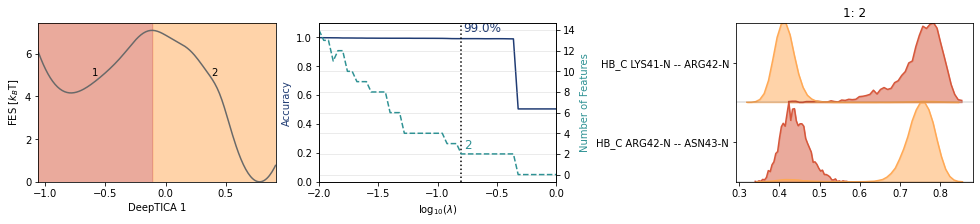

['DeepTICA 2']


Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:20<00:00,  2.50it/s]
/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/utils/plot.py:398: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Min = cv[mask].min().values[0]
/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/utils/plot.py:399: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Max = cv[mask].max().values[0]


log_10 (lambda) : -0.36
Accuracy        : 95.0 %
No. features    : 1
Basis quality   : 15 (lower the better)
Accuracy: 94%
State 2.2:
 HB_C TYR35-OHs -- CYS38-N


posx and posy should be finite values
posx and posy should be finite values


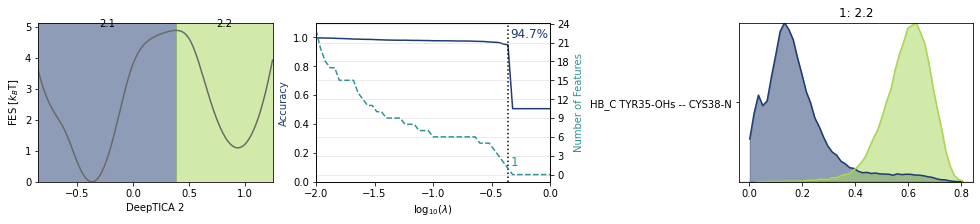

['DeepTICA 3']


Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:19<00:00,  2.59it/s]
/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/utils/plot.py:398: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Min = cv[mask].min().values[0]
/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/utils/plot.py:399: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Max = cv[mask].max().values[0]


log_10 (lambda) : -0.48
Accuracy        : 96.0 %
No. features    : 1
Basis quality   : 34 (lower the better)
Accuracy: 96%
State 2.1.2:
 HB_C PRO13-N -- CYS14-N


posx and posy should be finite values
posx and posy should be finite values


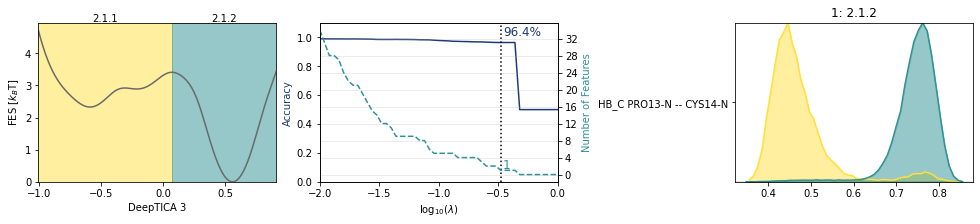

In [34]:
color_list = [[paletteFessa[6],paletteFessa[5],'grey'],[paletteFessa[0],paletteFessa[3],'grey'],[paletteFessa[4],paletteFessa[1],'grey']]

global_states_no = 0

results_list = []

for i,states_labels in enumerate(labels_list):

    states_subset = states_labels['labels'].unique()
    states_subset = states_subset[states_subset != 'undefined' ]

    cv_level = states_subset[0].count('.')+1
    cv_list = [f'DeepTICA {cv_level}']
    print(cv_list)

    result = train(cv_list,desc,states_labels,color=color_list[i])
    results_list.append(result)
    plt.show()

## Visualize features

Here we select the results of the first classification and plot samples of the protein along with the relevant features highlighted

In [11]:
(cv_list,states_labels,features_names,classifier,reg) = results_list[0]
relevant_feat = classifier.feature_summary(reg)

In [18]:
from importlib import reload
import stateinterpreter
reload(stateinterpreter)
reload(stateinterpreter.utils.visualize)

<module 'stateinterpreter.utils.visualize' from '/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/utils/visualize.py'>

In [12]:
import nglview 
import matplotlib
from stateinterpreter.utils.visualize import compute_residue_score,visualize_residue_score

n_residues = traj.n_residues
residue_score = compute_residue_score(classifier,reg,feats_info,n_residues)

states_subset = states_labels['labels'].unique()
states_subset = states_subset[states_subset != 'undefined' ]

classes_names = classifier.classes

view = visualize_residue_score(traj, states_labels, classes_names, residue_score, representation='cartoon', relevant_features=relevant_feat, features_info=feats_info)#,state_frames=[82957,0])
view

frames: [83581, 71916]
HB_C LYS41-N -- ARG42-N [628, 650]


NGLWidget(max_frame=1)

## Plot RMSD

In [13]:
# compute RMSD

import mdtraj as md

# Compute RMSD
traj = load_trajectory(traj_dict,stride=stride)
traj_file = traj_dict["trajectory"]
topo_file = traj_dict["topology"] if "topology" in traj_dict else None

traj = md.load(traj_file, top=topo_file, stride=stride)

file_ref = BPTI_data_path+'RMSD-reference.pdb'
rmsd_ref = md.load(topo_file)

df, _ = traj.top.to_dataframe()
# CA RMSD
rmsd = md.rmsd(traj,rmsd_ref,atom_indices=df [df['name'] == 'CA'].index)

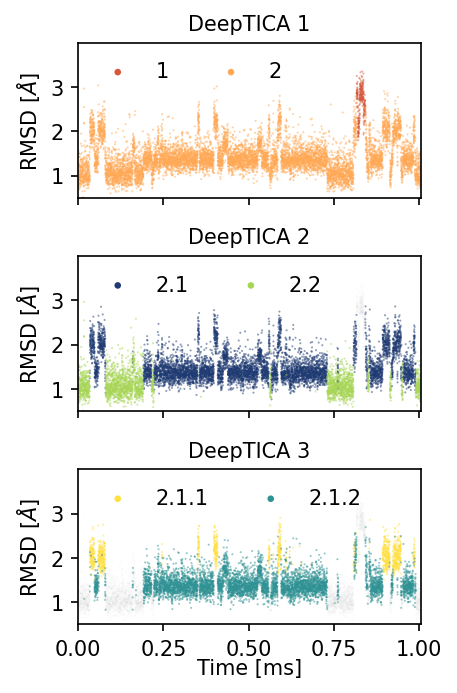

In [32]:
# select all samples from states
labels_list = generate_state_labels_from_tree(T,root='MD',fes_threshold=10)

t = np.arange(len(rmsd))*0.010/1000
N = 10

centimeters = 1/2.54
fig,axs = plt.subplots(3,1,dpi=150,figsize=(8*centimeters,4*centimeters*len(labels_list)),sharex=True,sharey=True)

for i,states_labels in enumerate(labels_list):
    states_subset = sorted(states_labels['labels'].unique())
    ax = axs[i]
    ax.set_ylim(0.5,4)
    ax.set_xlim(0,1.005)
    fontsize='medium'
    if i == len(labels_list)-1:
        ax.set_xlabel(r'Time [ms]', labelpad=-0.5 ,fontsize=fontsize)

    ax.set_ylabel(r'RMSD [$\AA$]',fontsize=fontsize)
    ax.set_yticks([1,2,3])
    ax.set_title(f'DeepTICA {i+1}',fontsize=fontsize)

    colors = iter(color_list[i])

    for label in states_subset:
        mask = (states_labels['labels'] == label)
        t_i = t[mask]
        rmsd_i = rmsd[mask]*10
        
        if label == 'undefined':
            c='silver'
            a=0.05
            l=None
        else:
            c=next(colors)
            a=0.5
            l=label
        ax.scatter(t_i[1::N],rmsd_i[1::N],facecolors=c,s=1,marker='o',edgecolors='none',alpha=a,rasterized=True)
        ax.scatter(-1,0,rasterized=True,s=10,label=l,marker='o',edgecolors='none',alpha=1,facecolors=c)

    
    ax.legend(frameon=False,loc='upper left',ncol=2)

plt.tight_layout()
plt.show()